In [1]:
import json
import gzip
import bz2
import lzma
import glob
from os.path import basename
from  collections import *
from tqdm.notebook import tqdm
import ast
import networkx as nx
import random
import pickle
from collections import Counter

# SETTINGS
year = '2018'
existing_graph = True
existing_party_ppr = True

# Construct the weighted bipartite graph from user to subreddit

### Build the graph

In [2]:
def build_bipartite_graph(directory, min_sub_threshold=500):
    files = glob.glob(directory)

    filtered_subreddits = get_subreddits_above_threshold(files, min_sub_threshold)
    g = nx.Graph()

    users = set()
    subreddits = set()

    for fname in tqdm(files, desc='Processing all files'):
        with open(fname, 'rt') as f:
            lines = f.readlines()

        for line in tqdm(lines, position=1, desc='Build graph from file'):
            user, subreddit, freq = line[:-1].split('\t')
            freq = int(freq)

            # distinguish users from subreddits
            subreddit = 'r/' + subreddit

            users.add(user)
            subreddits.add(subreddit)

            if subreddit in filtered_subreddits:
                if not g.has_node(user):
                    g.add_node(user)
                if not g.has_node(subreddit):
                    g.add_node(subreddit)

                if g.has_edge(user, subreddit):
                    g[user][subreddit]['weight'] += freq
                else:
                    g.add_edge(user, subreddit, weight=freq)

    return filter_single_edge_nodes(g)


def get_subreddits_above_threshold(files, min_sub_threshold):
    """ Get subreddits that have a given number of submissions """

    sub_frequencies = Counter()
    for fname in tqdm(files, desc='Processing all files'):
        with open(fname, 'rt') as f:
            lines = f.readlines()

        for line in tqdm(lines, position=1, desc='Build graph from file'):
            user, subreddit, freq = line[:-1].split('\t')
            subreddit = 'r/' + subreddit
            sub_frequencies[subreddit] += int(freq)

    return {sub: count for sub, count in sub_frequencies.items() if count >= min_sub_threshold}


def filter_single_edge_nodes(g):
    """ Get rid of users who only have an edge to one subreddit """
    to_remove = [n for (n, deg) in g.degree() if deg == 1]
    g.remove_nodes_from(to_remove)
    return g


def load_existing_graph(input_path):
    print("Loading in graph from {}".format(input_path))
    with open(input_path, 'rb') as handle:
        g = pickle.load(handle)
        return g
    
if existing_graph:
    print("Loading existing graph")
    location = '/shared/0/projects/reddit-political-affiliation/data/bipartite-networks/' + year + '_graph_filtered.pickle'
    g = load_existing_graph(location)
else:
    print("Building new graph")
    location = '/shared/0/projects/reddit-political-affiliation/data/bipartite-networks/' + year + '*.tsv'
    g = build_bipartite_graph(location)
    
    # Save the graph for next time
    out_dir = '/shared/0/projects/reddit-political-affiliation/data/bipartite-networks/'
    with open(out_dir + year + '_graph_filtered.pickle', 'wb') as handle:
        pickle.dump(g, handle, protocol=pickle.HIGHEST_PROTOCOL)

Loading existing graph
Loading in graph from /shared/0/projects/reddit-political-affiliation/data/bipartite-networks/2018_graph_filtered.pickle


# Load in the users flair-based labels

In [3]:
files = glob.glob('/shared/0/projects/reddit-political-affiliation/data/flair-affiliations/20*.tsv')

user_to_politic_counts = defaultdict(Counter)

for fname in tqdm(files):
    with open(fname, 'rt') as f:
        for line in f:
            user, politics, freq = line.split('\t')
            user_to_politic_counts[user][politics] += int(freq)
            
print("User to politic counts: " + str(len(user_to_politic_counts)))
print(list(user_to_politic_counts.items())[:10])


User to politic counts: 7832
[('unitedstates', Counter({'Republican': 36})), ('ixid', Counter({'Democrat': 77})), ('TheMG', Counter({'Democrat': 12})), ('MoosPalang', Counter({'Democrat': 2})), ('well_here_I_am', Counter({'Republican': 46})), ('madwilliamflint', Counter({'Republican': 3})), ('lannister80', Counter({'Democrat': 7})), ('dcgh96', Counter({'Republican': 12})), ('G-3-R', Counter({'Republican': 9})), ('Eat_The_Muffin', Counter({'Republican': 3}))]


# Canonicalize each user to a single affiliation; toss out those with more than one

In [4]:
user_to_politics = {}
for u, pc in user_to_politic_counts.items():
    if len(pc) > 1:
        continue
    user_to_politics[u] = list(pc.keys())[0]
print('Saw political affiliations for %d users' % len(user_to_politics))

Saw political affiliations for 7775 users


# Split in to test/train sets

In [5]:
all_identified_users = list(user_to_politics.keys())
random.seed(42)
random.shuffle(all_identified_users)

train_users = all_identified_users[:int(0.9*len(all_identified_users))]
test_users = all_identified_users[int(0.9*len(all_identified_users)):]
print(len(train_users), len(test_users))

6997 778


# Train personalized page rank for both parties

In [6]:
rep_users = set([k for k in train_users if user_to_politics[k] == 'Republican'])
dem_users = set([k for k in train_users if user_to_politics[k] == 'Democrat'])

print(len(rep_users), len(dem_users))

5018 1979


In [7]:
# REP PPR
out_dir = '/shared/0/projects/reddit-political-affiliation/data/ppr-scores/'

if existing_party_ppr:
    with open(out_dir + year + '_rep_ppr.pickle', 'rb') as handle:
        rep_ppr = pickle.load(handle)
else:
    n = g.number_of_nodes()
    rep_personalization = {}

    for n in tqdm(g.nodes, total=n):
        if n in rep_users:
            rep_personalization[n] = 1
        else:
            rep_personalization[n] = 0.00001

    rep_ppr = nx.pagerank(g, personalization=rep_personalization)
    with open(out_dir + year + '_rep_ppr.pickle', 'wb') as handle:
        pickle.dump(rep_ppr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
# DEM PPR
out_dir = '/shared/0/projects/reddit-political-affiliation/data/ppr-scores/'

if existing_party_ppr:
    with open(out_dir + year + '_dem_ppr.pickle', 'rb') as handle:
        dem_ppr = pickle.load(handle) 
else:
    n = g.number_of_nodes()
    dem_personalization = {}

    for n in tqdm(g.nodes, total=n):
        if n in dem_users:
            dem_personalization[n] = 1
        else:
            dem_personalization[n] = 0.00001
            
    dem_ppr = nx.pagerank(g, personalization=dem_personalization)
    with open(out_dir + year + '_dem_ppr.pickle', 'wb') as handle:
        pickle.dump(dem_ppr, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Null Model

1. Randomly select the same number of users
2. Compute PPR
3. Repeat ~30 times to get an estimate of the mean/standard-deviation
4. Calculate the z-score using the actual PPR and the estimated mean/stddev

Note - If there are k republican users, just pick k random users, e.g. random.sample(all_users, k) and use those as the “seed” users in the PPR

# Score Distributions

### Read in the null models

In [9]:
# Read in all of the null models and store the results
score_dist = defaultdict(list)
directory = '/shared/0/projects/reddit-political-affiliation/data/ppr-scores/' + year + '*.tsv'

files = glob.glob(directory)

for fname in tqdm(files, desc='Processing all files for year ' + year):
    with open(fname, 'rt') as f:
        lines = f.readlines()

    for line in tqdm(lines, position=1, desc='Reading user scores in from file'):
        user, score = line[:-1].split('\t')
        score_dist[user].append(score)

## Top Political Subreddits By Z-Scores

In [10]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Find the top PPR score (avg) and plot a distribution as a sanity check
print("Computing mean and variance for null models")
score_avg_dist = {}
score_std = {}
for user, scores in tqdm(score_dist.items(), desc='Processing null models for mean and std'):
    scores = np.array(scores, dtype=float)
    score_avg_dist[user] = np.mean(scores)
    score_std[user] = np.std(scores)

Computing mean and variance for null models


In [11]:
# Get all z-scores and store them
rep_z_scores, dem_z_scores = {}, {}

for user, score in tqdm(rep_ppr.items(), desc='Processing Republican PPR scores'):
    if score_std[user] == 0:
        continue
    rep_z_scores[user] = (score - score_avg_dist[user]) / score_std[user]
    
for user, score in tqdm(dem_ppr.items(), desc='Processing Democrat PPR scores'):
    if score_std[user] == 0:
        continue
    dem_z_scores[user] = (score - score_avg_dist[user]) / score_std[user]
    

out_dir = '/shared/0/projects/reddit-political-affiliation/data/z-scores/'
print("Saving results  to directory: " + out_dir)

with open(out_dir + year + '_rep_scores.pickle', 'wb') as handle:
    pickle.dump(rep_z_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(out_dir + year + '_dem_scores.pickle', 'wb') as handle:
    pickle.dump(dem_z_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)


Saving results  to directory: /shared/0/projects/reddit-political-affiliation/data/z-scores/


In [12]:
sub_rep_scores = {k: v for k, v in rep_z_scores.items() if k[:2] == 'r/' and k[2:4] != 'u_'}
sub_dem_scores = {k: v for k, v in dem_z_scores.items() if k[:2] == 'r/' and k[2:4] != 'u_'}
    
print("Sorting lists to the top political subreddits")
sub_rep_scores = {k: v for k, v in sorted(sub_rep_scores.items(), key=lambda item: item[1], reverse=True)}
sub_dem_scores = {k: v for k, v in sorted(sub_dem_scores.items(), key=lambda item: item[1], reverse=True)}

top_dem = dict(itertools.islice(sub_dem_scores.items(), 100))
top_rep = dict(itertools.islice(sub_rep_scores.items(), 100))

print("Top DEM Subreddits")
print(top_dem)

print("Top REP Subreddits")
print(top_rep)

Sorting lists to the top political subreddits
Top DEM Subreddits
{'r/nurseryrhymes': 272.91393091511776, 'r/SubredditSimulator': 178.87327296770604, 'r/MetaSpeaks': 113.69088102153212, 'r/NTSB_database': 106.64444161344147, 'r/RedditTrophies': 105.35271703259843, 'r/NewFishSpecies': 97.57888244611834, 'r/Republicancer': 97.19146461110604, 'r/nohair': 95.35894744701073, 'r/Shit_SPS_Says': 85.07534633294333, 'r/RedditMinusMods': 80.71163819547674, 'r/CANNABISfuturus': 78.94362725639974, 'r/InconvenientDemocrats': 75.84621135858238, 'r/MillionShekelExtreme': 73.13242054620649, 'r/gunsofliberty': 68.34547632073141, 'r/MINEFoundation': 66.83135310764358, 'r/DidTheVikingsWinSB': 62.3987083348105, 'r/BirdtownComics': 60.0392762199796, 'r/metaphotography': 58.63545071689235, 'r/doomsdaycult': 57.84071745278265, 'r/pitcnt': 56.31992946015402, 'r/CAchores': 54.791795792382175, 'r/both_sides': 52.76358478985953, 'r/classygirls': 51.69915801220503, 'r/uninsurable': 48.993935281944516, 'r/budgetcoo

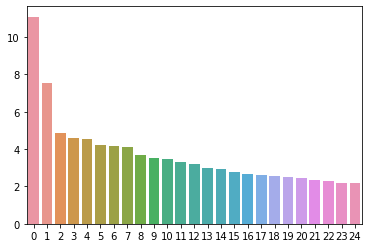

In [31]:
# Plot top Z-Scores for each
y = list(top_rep.values())[:25]
x = list(range(25))
sns.barplot(x, y)

# Politicalness Score

Sum the rep_ppr and dem_ppr for a user/subreddit and then normalize across all users and (separately) all subreddits to get a score of "politicalness". E.g., subreddits that have a higher score end up being visited more frequently by politically-active users

Correct bias using null model

# Predicting on the test set

Test whether the "political leaning" score predicts the affiliations for the users in the `test_users` set by seeing which affiliation (from the PPR score) is larger.

In [32]:
# Normalize z-scores
sum_dem_score = sum(list(dem_z_scores.values()))
sum_rep_score = sum(list(rep_z_scores.values()))

both = sum_dem_score + sum_rep_score

norm_dem, norm_rep = {}, {}

for user, score in dem_z_scores.items():
    norm_dem[user] = score / both 

for user, score in rep_z_scores.items():
    norm_rep[user] = score / both

In [33]:
from sklearn.metrics import accuracy_score


# Filter out data not present...
filtered_test = []
labels = []

for user in test_users:
    if user in rep_ppr and user in dem_ppr:
        filtered_test.append(user)
        labels.append(user_to_politics[user])

print("Size of test set: " + str(len(filtered_test)))

# Run prediction

def get_prediction(user):
    score = norm_rep[user] - norm_dem[user]
    if score < 0:
        return "Democrat"
    else:
        return "Republican"
    
    
predictions = [get_prediction(user) for users in filtered_test]
print(accuracy_score(labels, predictions))

Size of test set: 580
0.3086206896551724
